In [1]:
from fastai.conv_learner import *
from fastai.dataset import *

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import scipy.optimize as opt

In [2]:
# path 설정
PATH = './'
TRAIN = 'all/train/'
TEST = 'all/test/'
LABELS = 'all/train.csv'
SAMPLE = 'all/sample_submission.csv'

In [3]:
#라벨들의 이름
name_label_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [4]:
nw = 2
arch = resnet34 #Fastai library중 fastai.conv_learner에서 Resnet34를 import해온다.

In [5]:
#각 path에서 데이터들을 불러옴 
train_names = list({f[:36] for f in os.listdir(TRAIN)})
test_names = list({f[:36] for f in os.listdir(TEST)})
tr_n, val_n = train_test_split(train_names, test_size=0.1, random_state=42)

In [6]:
#cv2를 이용하여 RGBY image를 읽어온다.
def open_rgby(path,id): 
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

In [7]:
class ProteinDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.labels = pd.read_csv(LABELS).set_index('Id')
        self.labels['Target'] = [[int(i) for i in s.split()] for s in self.labels['Target']]
        super().__init__(fnames, transform, path)
    
    def get_x(self, i):
        img = open_rgby(self.path,self.fnames[i])
        if self.sz == 512: return img 
        else: return cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
    
    def get_y(self, i):
        if(self.path == TEST): return np.zeros(len(name_label_dict),dtype=np.int)
        else:
            labels = self.labels.loc[self.fnames[i]]['Target']
            return np.eye(len(name_label_dict),dtype=np.float)[labels].sum(axis=0)
        
    @property
    def is_multi(self): return True
    @property
    def is_reg(self):return True
    #이 플래그는 시그모이드 최적화를 허용하는 출력 시그모이드 제거용

    
    def get_c(self): return len(name_label_dict) #클래스 갯수

In [8]:
def get_data(sz,bs):
    
    # 데이터 확대 기법을 통해 데이터를 증가시킨다
    aug_tfms = [RandomRotate(30, tfm_y=TfmType.NO),
                RandomDihedral(tfm_y=TfmType.NO),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO)]
    
    #train set의 각 채널의 평균과 표준치
    stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
    tfms = tfms_from_stats(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.NO, 
                aug_tfms=aug_tfms)
    ds = ImageData.get_ds(ProteinDataset, (tr_n[:-(len(tr_n)%bs)],TRAIN), 
                (val_n,TRAIN), tfms, test=(test_names,TEST))
    md = ImageData(PATH, ds, bs, num_workers=nw, classes=None)
    return md

In [9]:
bs = 16   # 배치사이즈 16
sz = 256  # image 리사이즈 256

md = get_data(sz,bs)   

x,y = next(iter(md.trn_dl))
x.shape, y.shape

(torch.Size([16, 4, 256, 256]), torch.Size([16, 28]))

In [11]:
x_tot = np.zeros(4)
x2_tot = np.zeros(4)
for x,y in iter(md.trn_dl):
    tmp =  md.trn_ds.denorm(x).reshape(16,-1)
    x = md.trn_ds.denorm(x).reshape(-1,4)
    x_tot += x.mean(axis=0)
    x2_tot += (x**2).mean(axis=0)

channel_avr = x_tot/len(md.trn_dl)
channel_std = np.sqrt(x2_tot/len(md.trn_dl) - channel_avr**2)
channel_avr,channel_std

(array([0.08669, 0.0596 , 0.06513, 0.08883]),
 array([0.13048, 0.09818, 0.14858, 0.13291]))

In [12]:
#Loss function으로는 Facal loss를 사용하였다. 
#Focal loss는 교차 엔트로피를 발전시킨 function으로 학습과정에서 분류하기 쉬운 예제들은 학습에 기여하는 정도를 낮추고, 어려운 예제들에 대해 매우 집중시키는 function이다.
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [13]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [14]:
class ConvnetBuilder_custom():
    def __init__(self, f, c, is_multi, is_reg, ps=None, xtra_fc=None, xtra_cut=0, 
                 custom_head=None, pretrained=True):
        self.f,self.c,self.is_multi,self.is_reg,self.xtra_cut = f,c,is_multi,is_reg,xtra_cut
        if xtra_fc is None: xtra_fc = [512]
        if ps is None: ps = [0.25]*len(xtra_fc) + [0.5]
        self.ps,self.xtra_fc = ps,xtra_fc

        if f in model_meta: cut,self.lr_cut = model_meta[f]
        else: cut,self.lr_cut = 0,0
        cut-=xtra_cut
        layers = cut_model(f(pretrained), cut)
        
        
        #0으로 초기화
        w = layers[0].weight
        
        # resnet34는 RGB를 입력으로 받기때문에 3 channel을 입력으로 받는다.
        # 이 주제는 RGBY 를 입력으로 받기 때문에 첫번째 층을 4 channel을 입력받는 컨볼루션층으로 변경해준다
        layers[0] = nn.Conv2d(4,64,kernel_size=(7,7),stride=(2,2),padding=(3, 3), bias=False)
        layers[0].weight = torch.nn.Parameter(torch.cat((w,torch.zeros(64,1,7,7)),dim=1))
        
        self.nf = model_features[f] if f in model_features else (num_features(layers)*2)
        if not custom_head: layers += [AdaptiveConcatPool2d(), Flatten()]
        self.top_model = nn.Sequential(*layers)

        n_fc = len(self.xtra_fc)+1
        if not isinstance(self.ps, list): self.ps = [self.ps]*n_fc

        if custom_head: fc_layers = [custom_head]
        else: fc_layers = self.get_fc_layers()
        self.n_fc = len(fc_layers)
        self.fc_model = to_gpu(nn.Sequential(*fc_layers))
        if not custom_head: apply_init(self.fc_model, kaiming_normal)
        self.model = to_gpu(nn.Sequential(*(layers+fc_layers)))

    @property
    def name(self): return f'{self.f.__name__}_{self.xtra_cut}'

    # resnet에 배치정규화와 드롭아웃을 적용시킨 후 fc층을 추가한다.
    def create_fc_layer(self, ni, nf, p, actn=None):
        res=[nn.BatchNorm1d(num_features=ni)] # 배치정규화
        if p: res.append(nn.Dropout(p=p))     # 드롭아웃
        res.append(nn.Linear(in_features=ni, out_features=nf))  
        if actn: res.append(actn)
        return res

    def get_fc_layers(self):
        res=[]
        ni=self.nf
        for i,nf in enumerate(self.xtra_fc):
            res += self.create_fc_layer(ni, nf, p=self.ps[i], actn=nn.ReLU())
            ni=nf
        final_actn = nn.Sigmoid() if self.is_multi else nn.LogSoftmax()
        if self.is_reg: final_actn = None
        res += self.create_fc_layer(ni, self.c, p=self.ps[-1], actn=final_actn)
        return res

    def get_layer_groups(self, do_fc=False):
        if do_fc:
            return [self.fc_model]
        idxs = [self.lr_cut]
        c = children(self.top_model)
        if len(c)==3: c = children(c[0])+c[1:]
        lgs = list(split_by_idxs(c,idxs))
        return lgs+[self.fc_model]
    
class ConvLearner(Learner):
    def __init__(self, data, models, precompute=False, **kwargs):
        self.precompute = False
        super().__init__(data, models, **kwargs)
        if hasattr(data, 'is_multi') and not data.is_reg and self.metrics is None:
            self.metrics = [accuracy_thresh(0.5)] if self.data.is_multi else [accuracy]
        if precompute: self.save_fc1()
        self.freeze()
        self.precompute = precompute

    def _get_crit(self, data):
        if not hasattr(data, 'is_multi'): return super()._get_crit(data)

        return F.l1_loss if data.is_reg else F.binary_cross_entropy if data.is_multi else F.nll_loss

    @classmethod
    def pretrained(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                   pretrained=True, **kwargs):
        models = ConvnetBuilder_custom(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=pretrained)
        return cls(data, models, precompute, **kwargs)

    @classmethod
    def lsuv_learner(cls, f, data, ps=None, xtra_fc=None, xtra_cut=0, custom_head=None, precompute=False,
                  needed_std=1.0, std_tol=0.1, max_attempts=10, do_orthonorm=False, **kwargs):
        models = ConvnetBuilder(f, data.c, data.is_multi, data.is_reg,
            ps=ps, xtra_fc=xtra_fc, xtra_cut=xtra_cut, custom_head=custom_head, pretrained=False)
        convlearn=cls(data, models, precompute, **kwargs)
        convlearn.lsuv_init()
        return convlearn
    @property
    def model(self): return self.models.fc_model if self.precompute else self.models.model
    
    def half(self):
        if self.fp16: return
        self.fp16 = True
        if type(self.model) != FP16: self.models.model = FP16(self.model)
        if not isinstance(self.models.fc_model, FP16): self.models.fc_model = FP16(self.models.fc_model)
    def float(self):
        if not self.fp16: return
        self.fp16 = False
        if type(self.models.model) == FP16: self.models.model = self.model.module.float()
        if type(self.models.fc_model) == FP16: self.models.fc_model = self.models.fc_model.module.float()

    @property
    def data(self): return self.fc_data if self.precompute else self.data_

    def create_empty_bcolz(self, n, name):
        return bcolz.carray(np.zeros((0,n), np.float32), chunklen=1, mode='w', rootdir=name)

    def set_data(self, data, precompute=False):
        super().set_data(data)
        if precompute:
            self.unfreeze()
            self.save_fc1()
            self.freeze()
            self.precompute = True
        else:
            self.freeze()

    def get_layer_groups(self):
        return self.models.get_layer_groups(self.precompute)

    def summary(self):
        precompute = self.precompute
        self.precompute = False
        res = super().summary()
        self.precompute = precompute
        return res

    def get_activations(self, force=False):
        tmpl = f'_{self.models.name}_{self.data.sz}.bc'
        names = [os.path.join(self.tmp_path, p+tmpl) for p in ('x_act', 'x_act_val', 'x_act_test')]
        if os.path.exists(names[0]) and not force:
            self.activations = [bcolz.open(p) for p in names]
        else:
            self.activations = [self.create_empty_bcolz(self.models.nf,n) for n in names]

    def save_fc1(self):
        self.get_activations()
        act, val_act, test_act = self.activations
        m=self.models.top_model
        if len(self.activations[0])!=len(self.data.trn_ds):
            predict_to_bcolz(m, self.data.fix_dl, act)
        if len(self.activations[1])!=len(self.data.val_ds):
            predict_to_bcolz(m, self.data.val_dl, val_act)
        if self.data.test_dl and (len(self.activations[2])!=len(self.data.test_ds)):
            if self.data.test_dl: predict_to_bcolz(m, self.data.test_dl, test_act)

        self.fc_data = ImageClassifierData.from_arrays(self.data.path,
                (act, self.data.trn_y), (val_act, self.data.val_y), self.data.bs, classes=self.data.classes,
                test = test_act if self.data.test_dl else None, num_workers=8)

    def freeze(self):
        self.freeze_to(-1)

    def unfreeze(self):
        self.freeze_to(0)
        self.precompute = False

    def predict_array(self, arr):
        precompute = self.precompute
        self.precompute = False
        pred = super().predict_array(arr)
        self.precompute = precompute
        return pred


In [15]:
sz = 256 #이미지 사이즈
bs = 64  #배치 사이즈

md = get_data(sz,bs)
learner = ConvLearner.pretrained(arch, md, ps=0.5) 
learner.opt_fn = optim.Adam #Ada,
learner.clip = 1.0 #gradient clipping - 깊은 신경망에서 그래디언트가 폭발하는 걸 방지하기 위한 기법
learner.crit = FocalLoss()
learner.metrics = [acc]


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/ghyeon/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 111331098.03it/s]


In [16]:
# 신경망의 구조
learner.summary

<bound method ConvLearner.summary of Sequential(
  (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

  0%|          | 1/436 [00:05<40:41,  5.61s/it, loss=11.2]

/home/ghyeon/Downloads/fastai/old/fastai/model.py:62: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  if IS_TORCH_04: nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)


 77%|███████▋  | 334/436 [12:08<06:30,  3.83s/it, loss=9.13]

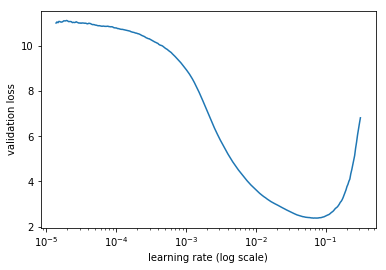

In [17]:
learner.lr_find() #최적의 학습 속도를 찾는다
learner.sched.plot()#편리한 플로팅 기능

In [18]:
lr = 2e-2
# 학습률 2e-2 로 학습
learner.fit(lr,1) 

epoch      trn_loss   val_loss   acc                        
    0      1.302338   1.220097   0.948761  


[1.2200969031111768, 0.9487613046798313]

In [19]:
#unfreeze 후 모든 전체 데이터 훈련.
learner.unfreeze()
lrs=np.array([lr/10,lr/3,lr])

In [20]:
# 적응적 학습률 적용
learner.fit(lrs/4,4,cycle_len=2,use_clr=(10,20))

epoch      trn_loss   val_loss   acc                         
    0      0.980588   0.914702   0.958333  
    1      0.851507   0.785226   0.963918                    
    2      0.861124   0.784006   0.963619                    
    3      0.777919   0.709684   0.967067                    
    4      0.800492   0.796726   0.962275                    
    5      0.735526   0.673616   0.968629                    
    6      0.777184   0.730949   0.9654                      
    7      0.699698   0.659516   0.968641                    


[0.6595157540596284, 0.9686408793910897]

In [21]:
learner.fit(lrs/4,2,cycle_len=4,use_clr=(10,20))

epoch      trn_loss   val_loss   acc                         
    0      0.770254   0.720628   0.966733  
    1      0.725861   0.689729   0.967423                    
    2      0.686687   0.631623   0.969801                    
    3      0.655511   0.607325   0.97133                     
    4      0.729992   0.721016   0.966297                    
    5      0.687845   0.663254   0.968641                    
    6      0.654915   0.628858   0.970135                    
    7      0.60769    0.584569   0.972939                    


[0.5845694482479931, 0.9729385437345566]

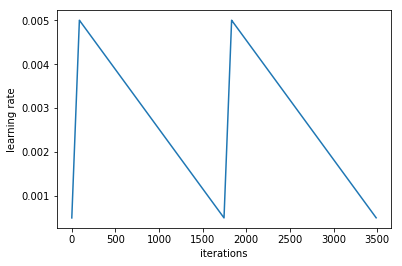

In [22]:
# 학습률 변화 확인
learner.sched.plot_lr()

In [23]:
learner.fit(lrs/16,1,cycle_len=8,use_clr=(5,20))

epoch      trn_loss   val_loss   acc                         
    0      0.603434   0.596352   0.971663  
    1      0.611073   0.602778   0.971927                    
    2      0.585828   0.584652   0.972916                    
    3      0.59314    0.579793   0.972743                    
    4      0.576192   0.579044   0.972962                    
    5      0.553661   0.577747   0.973295                    
    6      0.540244   0.566874   0.973594                    
    7      0.548968   0.568469   0.973869                    


[0.568468721408488, 0.9738693200483285]

In [24]:
learner.save('ResNet34_256_1') #모델 저장

In [25]:
#TTA를 사용하여 점수 평가
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds,y = learner.TTA(n_aug=16)
preds = np.stack(preds, axis=-1)
preds = sigmoid_np(preds)
pred = preds.max(axis=-1)

In [26]:
def F1_soft(preds,targs,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    targs = targs.astype(np.float)
    score = 2.0*(preds*targs).sum(axis=0)/((preds+targs).sum(axis=0) + 1e-6)
    return score

def fit_val(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x,y,p) - 1.0,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p


In [27]:
th = fit_val(pred,y)
th[th<0.1] = 0.1
print('Thresholds: ',th)
print('F1 macro: ',f1_score(y, pred>th, average='macro'))
print('F1 macro (th = 0.5): ',f1_score(y, pred>0.5, average='macro'))
print('F1 micro: ',f1_score(y, pred>th, average='micro'))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Thresholds:  [0.58865 0.54443 0.55037 0.55363 0.52724 0.54015 0.44707 0.52878 0.76861 0.47576 0.5689  0.6088  0.53235
 0.56532 0.62081 0.55313 0.51197 0.44589 0.49761 0.5118  0.43893 0.51829 0.51828 0.54291 0.55592 0.49568
 0.56861 0.5    ]
F1 macro:  0.6465814122914704
F1 macro (th = 0.5):  0.6137770434800792
F1 micro:  0.7603125927391433


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [28]:
print('Fractions: ',(pred > th).mean(axis=0))
print('Fractions (true): ',(y > th).mean(axis=0))

Fractions:  [0.43211 0.03732 0.09974 0.04118 0.06049 0.07207 0.03314 0.09492 0.00032 0.00129 0.00064 0.02671 0.01737
 0.01577 0.03604 0.00032 0.0074  0.00772 0.02349 0.04601 0.00869 0.11326 0.0222  0.09974 0.00933 0.32658
 0.00804 0.     ]
Fractions (true):  [0.41184 0.03797 0.10875 0.04794 0.06017 0.07465 0.02896 0.09427 0.00064 0.00193 0.00064 0.03539 0.01995
 0.02091 0.03636 0.00064 0.01512 0.00837 0.02735 0.04891 0.00579 0.10907 0.02188 0.10425 0.00933 0.26995
 0.00933 0.00032]


In [29]:
preds_t,y_t = learner.TTA(n_aug=16,is_test=True)
preds_t = np.stack(preds_t, axis=-1)
preds_t = sigmoid_np(preds_t)
pred_t = preds_t.max(axis=-1) 

In [30]:
def save_pred(pred, th=0.5, fname='protein_classification.csv'):
    pred_list = []
    for line in pred:
        s = ' '.join(list([str(i) for i in np.nonzero(line>th)[0]]))
        pred_list.append(s)
        
    sample_df = pd.read_csv(SAMPLE)
    sample_list = list(sample_df.Id)
    pred_dic = dict((key, value) for (key, value) 
                in zip(learner.data.test_ds.fnames,pred_list))
    pred_list_cor = [pred_dic[id] for id in sample_list]
    df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
    df.to_csv(fname, header=True, index=False)

In [31]:
th_t = np.array([0.565,0.39,0.55,0.345,0.33,0.39,0.33,0.45,0.38,0.39,
               0.34,0.42,0.31,0.38,0.49,0.50,0.38,0.43,0.46,0.40,
               0.39,0.505,0.37,0.47,0.41,0.545,0.32,0.1])
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t)

#임계값 자동 맞춤

Fractions:  [0.46052 0.05811 0.09716 0.09562 0.09836 0.14792 0.06478 0.1169  0.00256 0.0012  0.00128 0.04922 0.05068
 0.02008 0.04486 0.00009 0.03683 0.01965 0.03598 0.08161 0.01239 0.16655 0.04469 0.12203 0.01487 0.29063
 0.05657 0.03367]


In [32]:
lb_prob = [
 0.362397820,0.043841336,0.075268817,0.059322034,0.075268817,
 0.075268817,0.043841336,0.075268817,0.010000000,0.010000000,
 0.010000000,0.043841336,0.043841336,0.014198783,0.043841336,
 0.010000000,0.028806584,0.014198783,0.028806584,0.059322034,
 0.010000000,0.126126126,0.028806584,0.075268817,0.010000000,
 0.222493880,0.028806584,0.010000000]
# 반올림 오류날 수 있음으로 0을 0.01로 대체

In [40]:
def Count_soft(preds,th=0.5,d=50.0):
    preds = sigmoid_np(d*(preds - th))
    return preds.mean(axis=0)

def fit_test(x,y):
    params = 0.5*np.ones(len(name_label_dict))
    wd = 1e-5
    error = lambda p: np.concatenate((Count_soft(x,p) - y,
                                      wd*(p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [41]:
th_t = fit_test(pred_t,lb_prob)
th_t[th_t<0.1] = 0.1
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
print('Fractions (th = 0.5): ',(pred_t > 0.5).mean(axis=0))

Thresholds:  [0.64843 0.4694  0.62275 0.41826 0.37441 0.49776 0.38324 0.55637 0.24501 0.18202 0.14436 0.44905 0.33577
 0.46281 0.50215 0.22698 0.4115  0.48277 0.48947 0.456   0.41719 0.5557  0.44088 0.58694 0.51185 0.58591
 0.41452 0.17031]
Fractions:  [0.36301 0.04316 0.07494 0.05649 0.07144 0.07289 0.04162 0.07452 0.00931 0.00829 0.00684 0.04307 0.0411
 0.01401 0.04358 0.00752 0.02598 0.01376 0.02752 0.05785 0.00974 0.12485 0.0276  0.07392 0.01008 0.21902
 0.02752 0.00658]
Fractions (th = 0.5):  [0.53401 0.03905 0.11613 0.03504 0.03957 0.07212 0.01871 0.09332 0.0012  0.0006  0.00043 0.03487 0.01615
 0.01231 0.04358 0.00009 0.01213 0.01239 0.02512 0.04444 0.00359 0.17228 0.01957 0.1069  0.0106  0.37378
 0.01521 0.00009]


In [35]:
save_pred(pred_t,th_t,'protein_classification_f.csv')

In [36]:
#validation set과 0.5를 기준으로 계산된 임계값에 대한 예측값도 저장
save_pred(pred_t,th,'protein_classification_v.csv')
save_pred(pred_t,0.5,'protein_classification_05.csv')

In [37]:
class_list = [8,9,10,15,20,24,27]
for i in class_list:
    th_t[i] = th[i]
save_pred(pred_t,th_t,'protein_classification_c.csv')

In [38]:
#train set의 클래스 빈도수에 따른 임계값 피팅.
labels = pd.read_csv(LABELS).set_index('Id')
label_count = np.zeros(len(name_label_dict))
for label in labels['Target']:
    l = [int(i) for i in label.split()]
    label_count += np.eye(len(name_label_dict))[l].sum(axis=0)
label_fraction = label_count.astype(np.float)/len(labels)
label_count, label_fraction

(array([12885.,  1254.,  3621.,  1561.,  1858.,  2513.,  1008.,  2822.,    53.,    45.,    28.,  1093.,
          688.,   537.,  1066.,    21.,   530.,   210.,   902.,  1482.,   172.,  3777.,   802.,  2965.,
          322.,  8228.,   328.,    11.]),
 array([0.41468, 0.04036, 0.11654, 0.05024, 0.0598 , 0.08088, 0.03244, 0.09082, 0.00171, 0.00145, 0.0009 ,
        0.03518, 0.02214, 0.01728, 0.03431, 0.00068, 0.01706, 0.00676, 0.02903, 0.0477 , 0.00554, 0.12156,
        0.02581, 0.09542, 0.01036, 0.2648 , 0.01056, 0.00035]))

In [39]:
th_t = fit_test(pred_t,label_fraction)
th_t[th_t<0.05] = 0.05
print('Thresholds: ',th_t)
print('Fractions: ',(pred_t > th_t).mean(axis=0))
save_pred(pred_t,th_t,'protein_classification_t.csv')


Thresholds:  [0.60452 0.49402 0.50467 0.44369 0.4138  0.48552 0.42227 0.51156 0.45467 0.37377 0.39713 0.50205 0.44226
 0.41656 0.60129 0.3873  0.46794 0.57399 0.48864 0.49153 0.47102 0.56161 0.45821 0.53127 0.50198 0.56073
 0.5542  0.33789]
Fractions:  [0.41437 0.04008 0.11383 0.0482  0.05768 0.07776 0.03068 0.08956 0.00171 0.00137 0.00085 0.03487 0.02153
 0.01649 0.0341  0.00068 0.01683 0.00632 0.02769 0.04683 0.00538 0.12083 0.0247  0.09434 0.0106  0.26192
 0.01    0.00026]
